In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline

df = pd.read_csv(r'C:\Users\dearm\OneDrive\Documents\PYTORCH_NOTEBOOKS\Data\income.csv')

In [2]:
print(len(df))
df.head()

30000


,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,27,Male,HS-grad,9,Never-married,Private,Craft-repair,40,<=50K,0
1,47,Male,Masters,14,Married,Local-gov,Exec-managerial,50,>50K,1
2,59,Male,HS-grad,9,Divorced,Self-emp,Prof-specialty,20,<=50K,0
3,38,Female,Prof-school,15,Never-married,Federal-gov,Prof-specialty,57,>50K,1
4,64,Female,11th,7,Widowed,Private,Farming-fishing,40,<=50K,0


In [3]:
df['label'].value_counts()

label
0    21700
1     8300
Name: count, dtype: int64

In [4]:
df.columns

Index(['age', 'sex', 'education', 'education-num', 'marital-status',
       'workclass', 'occupation', 'hours-per-week', 'income', 'label'],
      dtype='object')

In [5]:
# separate continuous, categorical, and label column names from df
cat_cols = ['sex', 'education', 'marital-status', 'workclass', 'occupation']
cont_cols = ['age', 'hours-per-week']
y_col = ['label']

In [6]:
# convert categorical columns to category dtypes
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [7]:
# set embedding sizes
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(2, 1), (14, 7), (6, 3), (5, 3), (12, 6)]

In [8]:
# create array of categorical values
sx = df['sex'].cat.codes.values
ed = df['education'].cat.codes.values
ms = df['marital-status'].cat.codes.values
wc = df['workclass'].cat.codes.values
oc = df['occupation'].cat.codes.values

cats = np.stack([sx, ed, ms, wc, oc], axis=1)
cats[:5]

array([[ 1, 10,  3,  2,  1],
       [ 1, 11,  1,  1,  2],
       [ 1, 10,  0,  3,  7],
       [ 0, 12,  3,  0,  7],
       [ 0,  1,  5,  2,  3]], dtype=int8)

In [9]:
# convert cats to tensor
cats = torch.tensor(cats, dtype=torch.int64)

In [10]:
# create array of continuous values
conts = np.stack([df[col].values for col in cont_cols], 1)
conts[:5]

array([[27, 40],
       [47, 50],
       [59, 20],
       [38, 57],
       [64, 40]], dtype=int64)

In [11]:
# convert conts to tensor
conts = torch.tensor(conts, dtype=torch.float32)

In [12]:
# create a label tensor
y = torch.tensor(df[y_col].values).flatten()

In [13]:
# create train and test sets from cats, conts, and y
b = 30000 # batch size
t = 5000  # test size

cat_train = cats[:b-t]
cat_test = cats[b-t:b]
con_train = conts[:b-t]
con_test = conts[b-t:b]
y_train = y[:b-t]
y_test = y[b-t:b]

In [14]:
# define the model class
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        # Call the parent __init__
        super().__init__()
        
        # Set up the embedding, dropout, and batch normalization layer attributes
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Assign a variable to hold a list of layers
        layerlist = []
        
        # Assign a variable to store the number of embedding and continuous layers
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        # Iterate through the passed-in "layers" parameter (ie, [200,100]) to build a list of layers
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        
        # Convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        # Extract embedding values from the incoming categorical data
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        # Perform an initial dropout on the embeddings
        x = self.emb_drop(x)
        
        # Normalize the incoming continuous data
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        
        # Set up model layers
        x = self.layers(x)
        return x

In [15]:
# set a random seed
torch.manual_seed(33)

In [16]:
# create a TabularModel instance
model = TabularModel(emb_szs, conts.shape[1], 2, [50], p=0.4)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 3)
    (4): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [17]:
# define loss and optimization functions
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
# train the model!
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.detach().numpy())
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 0.81226683
epoch:  26  loss: 0.59122092
epoch:  51  loss: 0.51452035
epoch:  76  loss: 0.46413639
epoch: 101  loss: 0.42888343
epoch: 126  loss: 0.40092394
epoch: 151  loss: 0.37943089
epoch: 176  loss: 0.36461523
epoch: 201  loss: 0.35019812
epoch: 226  loss: 0.33694950
epoch: 251  loss: 0.33248594
epoch: 276  loss: 0.32154837
epoch: 300  loss: 0.31676286

Duration: 10 seconds


Text(0.5, 0, 'epoch')

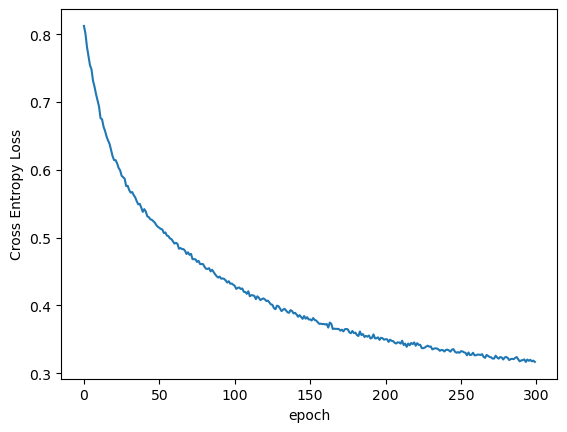

In [19]:
# plot the cross entropy loss against epochs, expect level off at small loss
plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch')

In [20]:
# evaluate the test set
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = criterion(y_val, y_test)

print(f'CE Loss: {loss:.8f}')

CE Loss: 0.32071865


In [21]:
# calculate overall accuracy in %
correct = 0
for i in range(len(y_val)):
    if y_val[i].argmax().item() == y_test[i]:
        correct += 1
print(f'\n{correct} out of {len(y_val)} = {100*correct/len(y_val):.2f}% correct')


4270 out of 5000 = 85.40% correct
